In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Import Data

In [2]:
time_unit = 'hour'
df = pd.read_csv(time_unit + '_summary.csv')
df.loc[:, 'time'] = pd.to_datetime(df.time)
df.sort_values('time', inplace=True)
df.head()

,time,value,value_0,value_1,value_2,value_3,value_4,value_5,value_6,value_7,...,value_38,value_39,value_40,value_41,value_42,value_43,value_44,value_45,value_46,value_47
0,2012-01-02 23:00:00,15.0,14.0,14.0,14.0,14.0,14.000000,14.000000,14.000000,14.000000,...,15.999293,15.958924,15.858934,15.705540,15.508279,15.279415,15.033179,15.0,15.0,15.0
1,2012-01-03 00:00:00,16.0,14.0,14.0,14.0,14.0,14.000000,14.000000,14.000000,14.108195,...,15.958924,15.858934,15.705540,15.508279,15.279415,15.033179,15.000000,15.0,15.0,16.0
2,2012-01-03 01:00:00,16.0,14.0,14.0,14.0,14.0,14.000000,14.000000,14.108195,14.350783,...,15.858934,15.705540,15.508279,15.279415,15.033179,15.000000,15.000000,15.0,16.0,16.0
3,2012-01-03 02:00:00,16.0,14.0,14.0,14.0,14.0,14.000000,14.108195,14.350783,14.571561,...,15.705540,15.508279,15.279415,15.033179,15.000000,15.000000,15.000000,16.0,16.0,16.0
4,2012-01-03 03:00:00,16.0,14.0,14.0,14.0,14.0,14.108195,14.350783,14.571561,14.756802,...,15.508279,15.279415,15.033179,15.000000,15.000000,15.000000,16.000000,16.0,16.0,16.0


### Test Train Split

In [3]:
X = df.iloc[:, 2:-1].to_numpy().astype(np.float32)
y = df.iloc[:,-1].to_numpy().astype(np.float32)
time_series = df.iloc[:,0]

In [4]:
indexes = np.array(np.arange(len(X)))
np.random.shuffle(indexes)
index_split = np.floor(0.66 * len(X)).astype(int)

In [5]:
X_train = X[indexes[:index_split]]
X_test = X[indexes[index_split:]]

y_train = y[indexes[:index_split]]
y_test = y[indexes[index_split:]]

time_series_train = time_series[indexes[:index_split]].to_numpy()
time_series_test = time_series[indexes[index_split:]].to_numpy()

In [6]:
sorted_index = np.argsort(time_series_test)
time_series_test = time_series_test[sorted_index]
X_test = X_test[sorted_index]
y_test = y_test[sorted_index]
time_series_test = pd.Series(time_series_test)

In [7]:
mean = X_train.mean()
sigma = X_train.std()
mean, sigma

(39.06719, 9.890111)

In [8]:
X_train_std = (X_train - mean)/sigma
X_test_std = (X_test - mean)/sigma
y_train_std = (y_train - mean)/sigma
y_test_std = (y_test - mean)/sigma

In [9]:
X_train_std = X_train_std.reshape(X_train.shape[0], X_train.shape[1], -1)
X_test_std = X_test_std.reshape(X_test.shape[0], X_test.shape[1], -1)
y_train_std = y_train_std.reshape(-1,1)
y_test_std = y_test_std.reshape(-1,1)

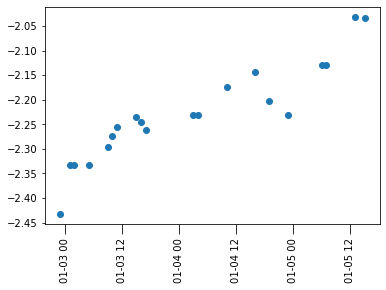

In [10]:
plt.plot(time_series_test[0:20], y_test_std[0:20], 'o')
plt.tick_params(axis='x', size=10, labelrotation = 90)
plt.show()

### Model

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [12]:
# Create Dataset objects.
trainset = TensorDataset(torch.from_numpy(X_train_std), torch.from_numpy(y_train_std))
testset = TensorDataset(torch.from_numpy(X_test_std), torch.from_numpy(y_test_std))

In [13]:
def create_model():
    # Custom layer that retrieves only last time step from RNN output.
    class LastTimestep(nn.Module):
        def forward(self, inputs):
            return inputs[1][0]

    # Create RNN model
    model = nn.Sequential(
        nn.RNN(1, 128, nonlinearity='relu', batch_first=True),
        LastTimestep(),
        nn.Linear(128, 1)
    )
    # Loss function and optimizer.
    optimizer = torch.optim.Adam(model.parameters())
    loss_function = nn.MSELoss()
    return model, optimizer, loss_function

In [14]:
epochs = 201
batch_size = 32

model, optimizer, loss_function = create_model()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

epoch_list, train_error, test_error = [], [], []

# Create dataloaders.
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

for i in range(epochs):

    # Training
    model.train()
    train_loss = 0.0
    train_absolute_error = 0.0
    train_batches = 0
    for inputs, targets in trainloader:

        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_function(outputs, targets)

        train_absolute_error += (targets - outputs.data).abs().sum().item()
        train_batches +=  1
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_loss = train_loss / train_batches
    train_mae = train_absolute_error / (train_batches * batch_size)

    # Evaluation
    model.eval()
    test_loss = 0.0
    test_absolute_error = 0.0
    test_batches = 0
    for inputs, targets in testloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        test_absolute_error += (targets - outputs.data).abs().sum().item()
        test_batches +=  1
        test_loss += loss.item()
    test_loss = test_loss / test_batches
    test_mae = test_absolute_error / (test_batches * batch_size)
    if i%10==0:
        print(f'Epoch {i+1}/{epochs} loss: {train_loss:.4f} - mae: {train_mae:0.4f} - val_loss: {test_loss:.4f} - val_mae: {test_mae:0.4f}')
        epoch_list.append(i)
        train_error.append(train_mae)
        test_error.append(test_mae)

Epoch 1/201 loss: 0.0219 - mae: 0.0467 - val_loss: 0.0142 - val_mae: 0.0229
Epoch 11/201 loss: 0.0120 - mae: 0.0231 - val_loss: 0.0144 - val_mae: 0.0253
Epoch 21/201 loss: 0.0119 - mae: 0.0218 - val_loss: 0.0142 - val_mae: 0.0259
Epoch 31/201 loss: 0.0118 - mae: 0.0220 - val_loss: 0.0142 - val_mae: 0.0220
Epoch 41/201 loss: 0.0118 - mae: 0.0227 - val_loss: 0.0142 - val_mae: 0.0228
Epoch 51/201 loss: 0.0117 - mae: 0.0225 - val_loss: 0.0141 - val_mae: 0.0250
Epoch 61/201 loss: 0.0117 - mae: 0.0223 - val_loss: 0.0139 - val_mae: 0.0216
Epoch 71/201 loss: 0.0116 - mae: 0.0222 - val_loss: 0.0138 - val_mae: 0.0210
Epoch 81/201 loss: 0.0117 - mae: 0.0234 - val_loss: 0.0139 - val_mae: 0.0202
Epoch 91/201 loss: 0.0116 - mae: 0.0225 - val_loss: 0.0138 - val_mae: 0.0222
Epoch 101/201 loss: 0.0116 - mae: 0.0224 - val_loss: 0.0143 - val_mae: 0.0309
Epoch 111/201 loss: 0.0116 - mae: 0.0209 - val_loss: 0.0137 - val_mae: 0.0202
Epoch 121/201 loss: 0.0115 - mae: 0.0193 - val_loss: 0.0137 - val_mae: 0.01

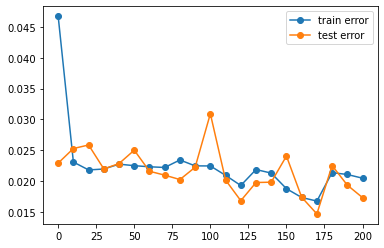

In [15]:
plt.plot(epoch_list, train_error, 'o-', label='train error')
plt.plot(epoch_list, test_error, 'o-', label='test error')
#plt.ylim(0.01, 0.07)
plt.legend()

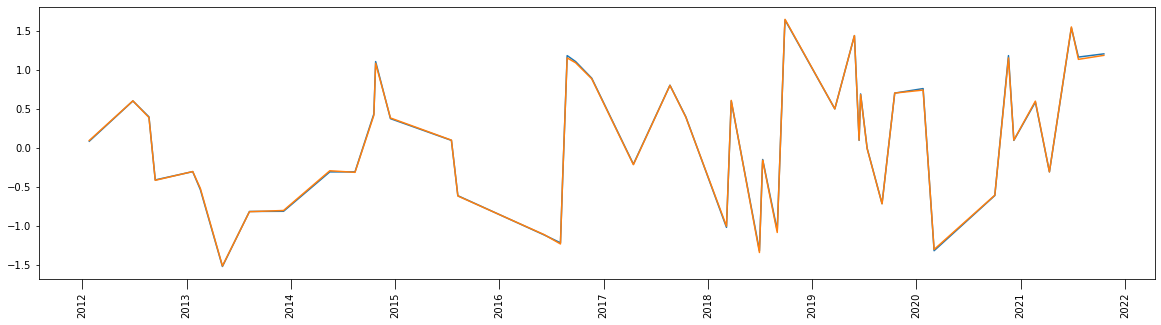

In [16]:
y_test_pred_std = model(torch.from_numpy(X_test_std)).detach().numpy()

idx_choice = np.random.choice(range(len(time_series_test)), 50)
idxs = [True if x in idx_choice else False for x in range(len(time_series_test))]

plt.figure(figsize=(20,5))
plt.plot(time_series_test[idxs], y_test_std[idxs], '-')
plt.plot(time_series_test[idxs], y_test_pred_std[idxs], '-')
plt.tick_params(axis='x', size=10, labelrotation = 90)
plt.show()

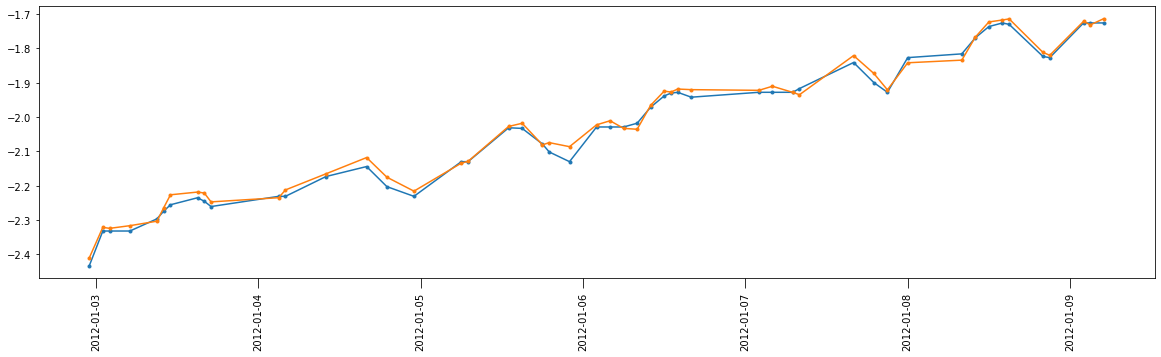

In [17]:
plt.figure(figsize=(20,5))
plt.plot(time_series_test[0:50], y_test_std[0:50], '.-')
plt.plot(time_series_test[0:50], y_test_pred_std[0:50], '.-')
plt.tick_params(axis='x', size=10, labelrotation = 90)
plt.show()

#### day transition

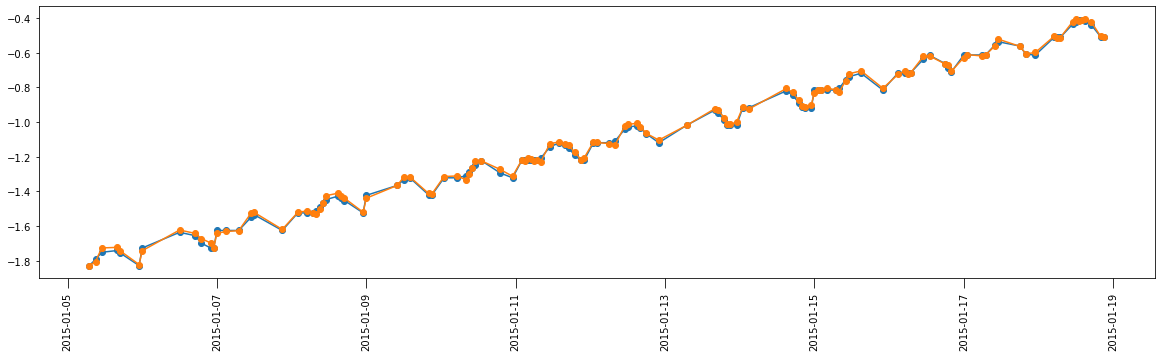

In [18]:
idxs = (time_series_test.dt.year==2015) & (time_series_test.dt.month==1) & (time_series_test.dt.isocalendar().week.isin([2,3]))
idxs = idxs.index[idxs]
plt.figure(figsize=(20,5))
plt.plot(time_series_test[idxs], y_test_std[idxs], 'o-')
plt.plot(time_series_test[idxs], y_test_pred_std[idxs], 'o-')
plt.tick_params(axis='x', size=10, labelrotation = 90)
plt.show()

#### month transition

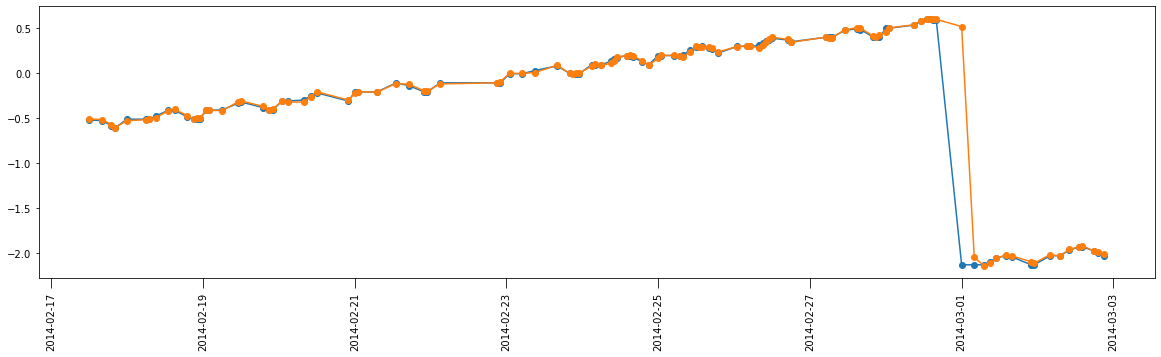

In [31]:
idxs = (time_series_test.dt.year==2014) & (time_series_test.dt.month.isin([2,3])) & (time_series_test.dt.isocalendar().week.isin([8,9]))
idxs = idxs.index[idxs]
plt.figure(figsize=(20,5))
plt.plot(time_series_test[idxs], y_test_std[idxs], 'o-')
plt.plot(time_series_test[idxs], y_test_pred_std[idxs], 'o-')
plt.tick_params(axis='x', size=10, labelrotation = 90)
plt.show()

#### year transition

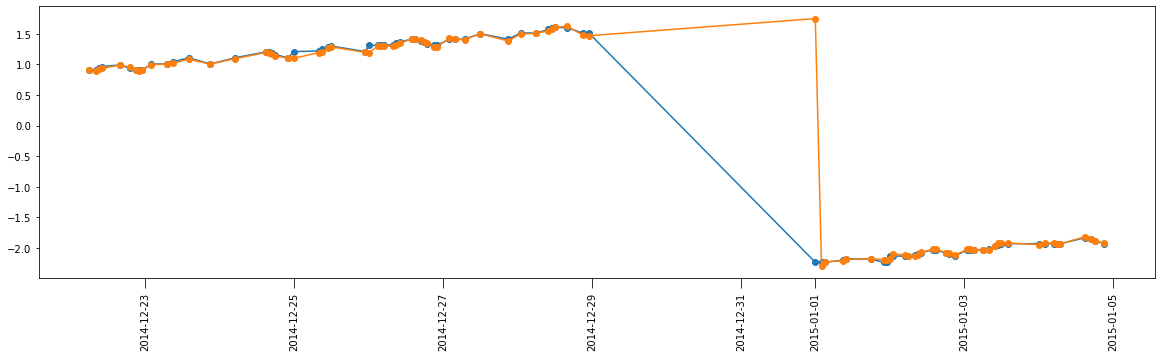

In [20]:
idxs = ((time_series_test.dt.year.isin([2015])) & (time_series_test.dt.isocalendar().week.isin([1]))) |\
        ((time_series_test.dt.year.isin([2014])) & (time_series_test.dt.isocalendar().week.isin([52,53])))
idxs = idxs.index[idxs]
plt.figure(figsize=(20,5))
plt.plot(time_series_test[idxs], y_test_std[idxs], 'o-')
plt.plot(time_series_test[idxs], y_test_pred_std[idxs], 'o-')
plt.tick_params(axis='x', size=10, labelrotation = 90)
plt.show()